# Machine learning for Portfolio Management and Trading

Dans ce projet, nous allons nous créer une stratégie d'investissement basé sur trois couches différentes: 

1 une couche de random forest pour la prediction
2 une couche  experte dans l'attribution des poids à chacun des prédicteurs
3 une couche de risk management et de décision qui réalise les ordres sur le marché
 
 Cette stratégie est inspiré de l'article "Automated trading with performance weighted random forests and seasonality" publié par Ash Booth, Enrico Gerding and Frank McGroarty.

Présentation

In [40]:
%matplotlib inline 
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler
import holidays
from datetime import date, timedelta
from workalendar.europe import Germany
from itertools import accumulate
import matplotlib.pyplot as plt
import calendar


# 1) Importation des data

Nous avons fait le choix de travailler sur des données du CAC 40 entre ... et ..... Afin de les extraires, nous avons décider de nous baser sur l'API offerte par Yahoo Finance.

Scrapping des tickers

In [41]:
linkScrappingCAC40= "https://en.wikipedia.org/wiki/CAC_40"
linkScrappingDAX= "https://en.wikipedia.org/wiki/DAX"
CAC40ticker = pd.read_html(linkScrappingCAC40)[4]["Ticker"].tolist()
DAXticker = pd.read_html(linkScrappingDAX)[4]["Ticker"].tolist()

In [42]:
DAXticker.remove("1COV.DE")

fonction d'extractions de data

In [43]:
#Acces à une echelle de temps plus fine, mais proche du présente
def datasetGenerationPresentOption(tickers,period,interval):# startDate,endDate
    data = yf.download(tickers,period = period,interval=interval)
    return data

#Acces à toutes les datas dans le temps, mais à une précision d'une journée seuelement
def datasetGenerationPast(tickers, startDate,endDate,interval="1d"):# startDate,endDate
    data = yf.download(tickers,start=startDate, end=endDate,interval=interval)
    return data

In [44]:
startDate=datetime.date(2000, 1, 1)
endDate=datetime.date(2010, 12, 31)

In [45]:
dataCAC40=datasetGenerationPresentOption(CAC40ticker,"1mo","15m")
dataDAX=datasetGenerationPast(DAXticker,startDate,endDate)
DAXindex = datasetGenerationPast('^GDAXI',startDate,endDate)
CAC40index = datasetGenerationPast('^FCHI',startDate,endDate)

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  39 of 39 completed

5 Failed downloads:
- ZAL.DE: Data doesn't exist for startDate = 946681200, endDate = 1293750000
- DTG.DE: Data doesn't exist for startDate = 946681200, endDate = 1293750000
- VNA.DE: Data doesn't exist for startDate = 946681200, endDate = 1293750000
- SHL.DE: Data doesn't exist for startDate = 946681200, endDate = 1293750000
- ENR.DE: Data doesn't exist for startDate = 946681200, endDate = 1293750000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [46]:
DAXindex

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,6961.720215,7159.330078,6720.870117,6750.759766,6750.759766,43072500
2000-01-04,6747.240234,6755.359863,6510.459961,6586.950195,6586.950195,46678400
2000-01-05,6585.850098,6585.850098,6388.910156,6502.069824,6502.069824,52682800
2000-01-06,6501.450195,6539.310059,6402.629883,6474.919922,6474.919922,41180600
2000-01-07,6489.939941,6791.529785,6470.140137,6780.959961,6780.959961,56058900
...,...,...,...,...,...,...
2010-12-23,7083.080078,7083.080078,7042.580078,7057.689941,7057.689941,42131200
2010-12-27,7055.319824,7056.339844,6943.049805,6970.729980,6970.729980,44519600
2010-12-28,6984.850098,6990.810059,6957.649902,6972.100098,6972.100098,32268800


In [47]:
dataDAX

Adj Close                                                          \
               ADS.DE     AIR.DE      ALV.DE     BAS.DE    BAYN.DE     BEI.DE   
Date                                                                            
2000-01-03  13.032961   9.955472  139.576157   9.756276  23.011738  15.176480   
2000-01-04  12.573507   9.955472  139.576157   9.479975  22.083452  16.164562   
2000-01-05  12.275392   9.955472  138.916748   9.117926  21.497166  14.570876   
2000-01-06  12.801480   9.955472  144.631683   9.152224  21.570452  14.935149   
2000-01-07  12.626119   9.955472  148.654099   9.527614  22.469427  15.251611   
...               ...        ...         ...        ...        ...        ...   
2010-12-23  40.890377  14.464869   51.394630  34.281334  38.029568  35.925102   
2010-12-27  40.343552  14.675323   50.933102  33.857147  37.592216  35.890488   
2010-12-28  40.404762  14.452727   51.086948  33.823658  37.491291  35.951092   
2010-12-29  40.514942  14.485105   51.109745  34.242264  37.585491  36.280075   
2010-12-30  39.902809  14.610570   50.671009  33.321323  37.208691  35.951092   

                                                        ...  Volume           \
               BMW.DE     BNR.DE     CON.DE     DB1.DE  ...  QIA.DE   RWE.DE   
Date                                                    ...                    
2000-01-03  15.147884        NaN  11.735324        NaN  ...   67230  1236054   
2000-01-04  14.536625        NaN  11.285117        NaN  ...  171931  1448199   
2000-01-05  14.248976        NaN  11.285117        NaN  ...  233106  1475345   
2000-01-06  14.202744        NaN  11.735324        NaN  ...   46002   935343   
2000-01-07  14.177062        NaN  11.435189        NaN  ...  133536  1538811   
...               ...        ...        ...        ...  ...     ...      ...   
2010-12-23  38.345844  19.517780  45.140907  37.752357  ...  214088  1212381   
2010-12-27  35.896950  19.556532  43.188469  37.493732  ...  161242  1111190   
2010-12-28  35.308975  19.406696  43.672913  37.572754  ...  259824  1066527   
2010-12-29  35.593868  19.401527  43.533451  37.651775  ...  220566  1186231   
2010-12-30  35.672668  19.711538  43.408669  37.213547  ...  195176  1063513   

                                                                              
             SAP.DE SHL.DE   SIE.DE SRT3.DE    SY1.DE VNA.DE  VOW3.DE ZAL.DE  
Date                                                                          
2000-01-03  2006460    NaN  2171195   15600       NaN    NaN   186288    NaN  
2000-01-04  3392856    NaN  3083994    2000       NaN    NaN   124950    NaN  
2000-01-05  4344624    NaN  3550309     800       NaN    NaN   165920    NaN  
2000-01-06  2219904    NaN  2999054       0       NaN    NaN   148235    NaN  
2000-01-07  7155936    NaN  3528472     800       NaN    NaN   103079    NaN  
...             ...    ...      ...     ...       ...    ...      ...    ...  
2010-12-23  1206471    NaN  1659923    9880  273691.0    NaN   402277    NaN  
2010-12-27  1018812    NaN  1363014   24520  266811.0    NaN  1152431    NaN  
2010-12-28   863728    NaN   850413   38996  130869.0    NaN   921192    NaN  
2010-12-29  1094616    NaN  1232412   16084  329568.0    NaN   551813    NaN  
2010-12-30  1419545    NaN  1762393   19380  136693.0    NaN   363673    NaN  

[2836 rows x 234 columns]

# 2) Check de la pertinance des évennements saisonniers/ faire les les mêmes graphes que l'article

### Week end

##### Stock par stock

In [48]:
dax_ret = dataDAX.Close.diff()
dax_ret[np.isnan(dax_ret)] = 0
dax_ret["weekday"] = pd.to_datetime(dax_ret.index)
dax_ret["weekday"] = dax_ret["weekday"].apply(lambda x : x.weekday())
monday_returns = dax_ret.loc[dax_ret.weekday==0]
monday_returns = monday_returns.drop(["weekday"],axis=1)


In [49]:
###Donne un dataset contennant pour chacun des stock la différence entre l'open du Lundi 
###et le close du Vendredi
def weekend(data):  
    dataFriday =data["Close"]
    dataFriday=dataFriday.dropna(axis=1)
    colonnes=dataFriday.columns
    
    dataFriday["key"]=dataFriday.index
        
    dataClose =data["Close"]
    dataClose=dataClose.dropna(axis=1)
    
    dataClose["weekday"] = pd.to_datetime(dataClose.index)
    dataClose["weekday2"] =dataClose["weekday"].apply(lambda x : x.weekday())
    dataClose=dataClose[dataClose["weekday2"]==4]
    dataClose["key"] =dataClose["weekday"].apply(lambda x : x + timedelta(days=3))
    
    newDataset=pd.merge(dataClose,dataFriday,how='left',on="key",suffixes=['','_2'])
    newDataset=newDataset.dropna(axis=0)
    newDataset= soustractionColumns(newDataset,colonnes)
    return newDataset

###Permet de soustraire entre l'open du Lundi et le close du Vendredi (data inclus dans l'input) 
###pour chacun des stocks
def soustractionColumns(data,colonnes): 
    newDataset=pd.DataFrame()
    for entreprise in colonnes :
        #print(entreprise,type(entreprise))
        nom1="-"+entreprise
        nom2="%"+entreprise
        newDataset[nom1]=data[entreprise+"_2"]-data[entreprise]
        #newDataset[nom2]=data[entreprise+"_2"]/data[entreprise]-1
    return newDataset

In [50]:
weekendDifferenceDAX =weekend(dataDAX)

In [51]:
weekendDifferenceDAX

,-ADS.DE,-AIR.DE,-ALV.DE,-BAS.DE,-BAYN.DE,-BEI.DE,-BMW.DE,-CON.DE,-DBK.DE,-DTE.DE,...,-MBG.DE,-MRK.DE,-MUV2.DE,-PUM.DE,-QIA.DE,-RWE.DE,-SAP.DE,-SIE.DE,-SRT3.DE,-VOW3.DE
0,0.272499,0.000000,1.950012,0.110001,1.643440,0.336666,1.100000,0.000000,-1.701088,1.520004,...,2.129997,0.270775,2.000000,0.090000,3.700039,-0.189369,1.766670,6.783211,0.0000,0.218683
1,0.162500,0.000000,-1.950012,0.184999,1.230118,0.746668,0.080000,-0.125713,1.732162,1.959999,...,-2.460007,0.344623,4.500000,-0.094000,0.776251,-0.448505,-0.750000,2.916779,0.0125,1.033781
2,0.112499,0.000000,-4.500000,-0.434999,0.246025,-0.166666,-1.000000,-0.290108,-1.483597,-2.449997,...,-1.189995,0.098463,-8.000000,0.062000,2.751925,-0.538208,1.750000,3.536957,-0.0125,-0.248507
3,-1.172500,0.000000,-13.620026,-0.600000,-1.210438,-1.150000,-1.420000,-0.435161,-1.196198,-2.500000,...,-1.750000,-0.196927,-14.860016,-0.015000,-2.284616,-1.395351,-3.541672,-11.618668,-0.0250,-0.427429
4,1.075000,0.000000,2.899994,-0.660000,-1.082504,-0.266666,-0.359999,0.125712,-0.543728,-4.800003,...,-0.769997,-0.541551,-8.889984,0.034000,-2.855770,0.199335,-0.029171,1.453552,-0.0275,-0.208746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,0.235001,-0.210001,-0.510002,0.419998,-0.669186,-0.625000,1.020000,0.869999,-0.480961,-0.080000,...,-0.180000,-0.029999,-0.800003,-0.275000,-0.166155,-0.219269,-0.285000,-0.058144,0.0625,3.200005
559,-0.759998,-0.190001,-1.330002,-2.070000,-1.515507,-0.880001,-1.509998,-1.980000,-0.978947,-0.102000,...,-1.750000,-0.180000,-1.250000,-0.440001,-0.218077,-0.807312,-0.600002,-1.308189,-0.0100,-3.049995
560,-0.275002,-0.164999,-0.570000,0.830002,0.452682,0.965000,-0.879997,1.349998,-0.523521,-0.110000,...,-0.330002,0.065001,-0.599998,0.210001,0.067500,-0.274086,-0.049999,0.348846,0.0250,1.250000
561,0.330002,-0.065001,0.119995,0.189999,-0.777435,-0.910000,0.919998,-0.169998,0.225594,-0.047000,...,-0.110001,-0.150000,-0.300003,0.174999,-0.129808,0.358807,0.234997,0.474823,0.0000,2.399994


In [52]:
numberOfObservation = (weekendDifferenceDAX > 0).sum().sum()
l,L =np.shape(weekendDifferenceDAX)
size=l*L
pourcentage= np.round(numberOfObservation/size*100,2)
print("L'évènement apparait dans",pourcentage,"% des cas")

L'évènement apparait dans 48.78 % des cas


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


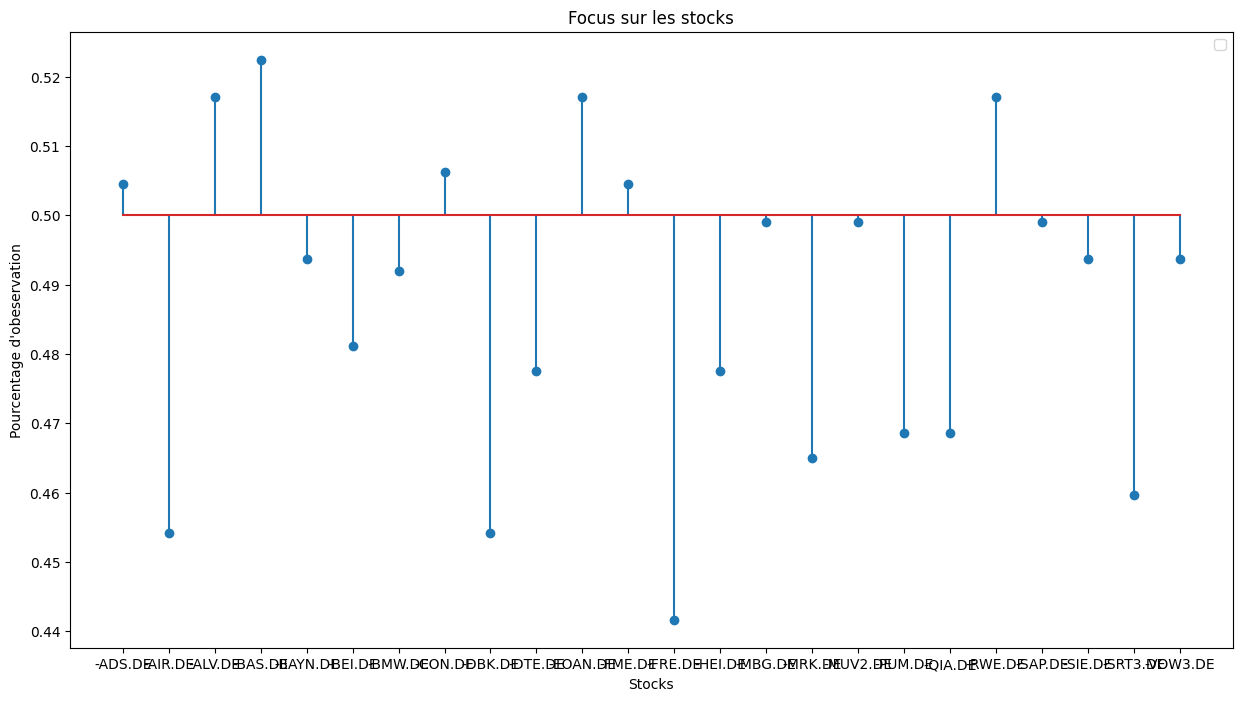

In [53]:
focusParStock= (weekendDifferenceDAX > 0).sum()/l
focusParStock


plt.figure(figsize=(15,8))
plt.stem(focusParStock.index,focusParStock,bottom=0.5)

plt.title("Focus sur les stocks")
plt.xlabel('Stocks')
plt.ylabel("Pourcentage d'obeservation")

plt.legend()

##### Index global

In [54]:
def weekendIndex(data):
    
    data["weekday"] = pd.to_datetime(data.index)
    data["weekday2"] =data["weekday"].apply(lambda x : x.weekday())
    
    dataClose=data[data["weekday2"]==4 ]
    dataClose["key"] =dataClose["weekday"].apply(lambda x : x + timedelta(days=3))
    
    dataOpen=data[data["weekday2"]==0 ]
    dataOpen["key"] =dataOpen.index
    
    newDataset=pd.merge(dataClose,dataOpen,how='left',on="key",suffixes=['','_2'])
    newDataset["gain"]=newDataset["Close_2"]-newDataset["Open"]
    
    return newDataset

In [55]:
weekendDifferenceDAXindex= weekendIndex(DAXindex)
gainweekendDifferenceDAXindex = weekendDifferenceDAXindex["gain"]

<ipython-input-54-a465b5af355a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataClose["key"] =dataClose["weekday"].apply(lambda x : x + timedelta(days=3))
<ipython-input-54-a465b5af355a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataOpen["key"] =dataOpen.index


In [56]:
numberOfObservation = (gainweekendDifferenceDAXindex > 0).sum()
size =len(gainweekendDifferenceDAXindex)
pourcentage= np.round(numberOfObservation/size*100,2)
print("L'évènement apparait dans",pourcentage,"% des cas")

L'évènement apparait dans 52.71 % des cas


In [57]:
weekendDAX=weekendDifferenceDAXindex[["gain","key"]]
#weekendDAX["Month"]=weekendDAX["key"].apply(lambda x : calendar.month_name[x.month])
weekendDAX["Month"]=weekendDAX["key"].apply(lambda x : x.month)
weekendDAX["observation"]=(weekendDAX["gain"]>0)
weekendDAX["#observation"]=1
weekendDAX=weekendDAX.groupby(by="Month")[["observation","#observation"]].sum()

<ipython-input-57-52798d295345>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekendDAX["Month"]=weekendDAX["key"].apply(lambda x : x.month)
<ipython-input-57-52798d295345>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekendDAX["observation"]=(weekendDAX["gain"]>0)
<ipython-input-57-52798d295345>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [58]:
weekendDAX["pourcentage"]=weekendDAX["observation"]/weekendDAX["#observation"]
weekendDAX.index=weekendDAX.index.map(lambda x :calendar.month_name[x])

In [59]:
weekendDAX

,observation,#observation,pourcentage
Month,,,
January,23,46,0.500000
February,21,44,0.477273
March,23,47,0.489362
April,22,38,0.578947
May,27,48,0.562500
June,19,47,0.404255
July,31,49,0.632653
August,21,48,0.437500
September,24,47,0.510638


Text(0, 0.5, "Pourcentage d'obeservation")

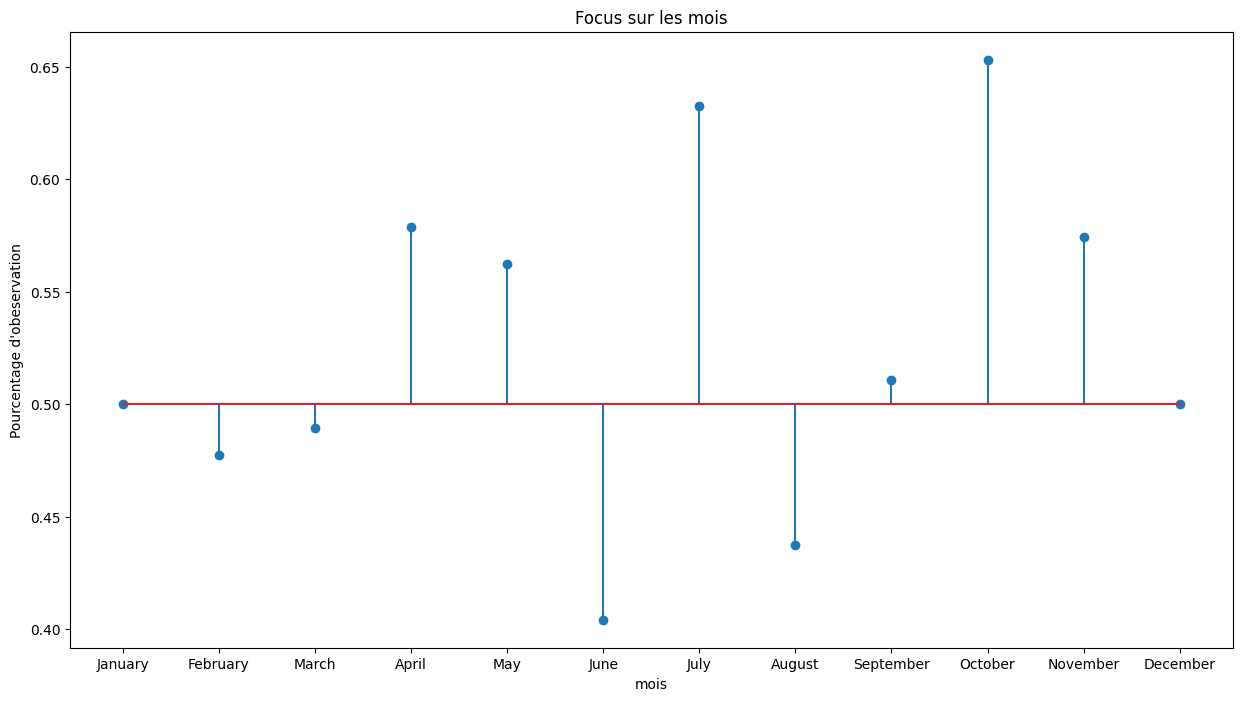

In [60]:
plt.figure(figsize=(15,8))


plt.stem(weekendDAX.index,weekendDAX["pourcentage"],bottom=0.5)

plt.title("Focus sur les mois")
plt.xlabel('mois')
plt.ylabel("Pourcentage d'obeservation")


### Holyday (Germany)

In [61]:
listeAnnee= np.arange(2000,2011)
holiday_list = []
for holiday in holidays.Germany(years=listeAnnee).items():
    holiday_list.append(holiday)

holidays_date = pd.DataFrame(holiday_list, columns=["date", "holiday"])
holidays_date["DayBeforeMarket"]=0
holidays_date["DayAfterMarket"]=0
holidays_date["ValueBeforeMarket"]=0
holidays_date["ValueAfterMarket"]=0
holidays_date
#####Ils ont deux jours fériés à noel, on fait quoi???

,date,holiday,DayBeforeMarket,DayAfterMarket,ValueBeforeMarket,ValueAfterMarket
0,2000-01-01,Neujahr,0,0,0,0
1,2000-04-21,Karfreitag,0,0,0,0
2,2000-04-24,Ostermontag,0,0,0,0
3,2000-05-01,Erster Mai,0,0,0,0
4,2000-06-01,Christi Himmelfahrt,0,0,0,0
...,...,...,...,...,...,...
93,2010-05-13,Christi Himmelfahrt,0,0,0,0
94,2010-05-24,Pfingstmontag,0,0,0,0
95,2010-10-03,Tag der Deutschen Einheit,0,0,0,0
96,2010-12-25,Erster Weihnachtstag,0,0,0,0


In [62]:
def hollydaysIndex(data,holidays_date):
    l,L= np.shape(holidays_date)
    for line in range(l):
        dateHoliday=str(holidays_date.iloc[line,0])
        
        if holidays_date.iloc[line,0] in data["date"]:
            rang=data["date"].searchsorted(dateHoliday, side='right') 
            holidays_date.loc[line,tableau]=data["date"][rang-2]
            holidays_date.loc[line,"DayAfterMarket"]=data["date"][rang]
            holidays_date.loc[line,"ValueBeforeMarket"]=data["Close"][rang-2]
            holidays_date.loc[line,"ValueAfterMarket"]=data["Open"][rang]
            
        else :
            rang=data["date"].searchsorted(dateHoliday, side='right') 
            holidays_date.loc[line,"DayBeforeMarket"]=data["date"][rang-1]
            holidays_date.loc[line,"DayAfterMarket"]=data["date"][rang]
            holidays_date.loc[line,"ValueBeforeMarket"]=data["Close"][rang-1]
            holidays_date.loc[line,"ValueAfterMarket"]=data["Open"][rang]
            
    holidays_date["Gain"]= holidays_date["ValueAfterMarket"]-holidays_date["ValueBeforeMarket"]
    holidays_date.drop_duplicates(subset ="DayBeforeMarket", inplace=True)

    return holidays_date

In [63]:
DAXindex["date"]=DAXindex.index
tableau=hollydaysIndex(DAXindex,holidays_date)
pourcentage= round((tableau["Gain"]>0).sum()/(tableau["Gain"]!="").sum()*100,2)
print("L'évènement apparait dans",pourcentage,"% des cas")

L'évènement apparait dans 60.53 % des cas


In [64]:
tableau["Observation"]= (tableau["Gain"]>0)
tableau["#Observation"]= 1
#df.groupby(level="Type").mean()
tableau2=tableau.groupby(by=["holiday"])[["Observation"]].mean()
tableau2["#Observation"]=tableau.groupby(by=["holiday"]).sum()['#Observation']
tableau2

<ipython-input-64-908b58d7f545>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tableau2["#Observation"]=tableau.groupby(by=["holiday"]).sum()['#Observation']


,Observation,#Observation
holiday,,
Christi Himmelfahrt,0.600000,10
"Christi Himmelfahrt, Erster Mai",1.000000,1
Erster Mai,0.600000,10
Erster Weihnachtstag,0.818182,11
Karfreitag,0.545455,11
Neujahr,0.727273,11
Pfingstmontag,0.454545,11
Tag der Deutschen Einheit,0.454545,11


### Changement de mois

In [65]:
dataMonths=pd.DataFrame()  
dataMonths["date"] =pd.date_range(startDate,endDate,freq='MS')
dataMonths["weekday"]=dataMonths["date"].apply(lambda x : x.weekday())
dataMonths["firstMonMonth"]=dataMonths.apply(lambda x : x.date+timedelta(days=7-x.weekday), axis=1)
dataMonths["LastFraidayMonth"]=dataMonths.apply(lambda x : x.date-timedelta(days=x.weekday+3), axis=1)
#dataMonths["LastFraidayMonthVerif"]=dataMonths["LastFraidayMonth"].apply(lambda x : x.weekday())
#dataMonths["firstMonMonthVerif"]=dataMonths["firstMonMonth"].apply(lambda x : x.weekday())

In [66]:
dataMonths

,date,weekday,firstMonMonth,LastFraidayMonth
0,2000-01-01,5,2000-01-03,1999-12-24
1,2000-02-01,1,2000-02-07,2000-01-28
2,2000-03-01,2,2000-03-06,2000-02-25
3,2000-04-01,5,2000-04-03,2000-03-24
4,2000-05-01,0,2000-05-08,2000-04-28
...,...,...,...,...
127,2010-08-01,6,2010-08-02,2010-07-23
128,2010-09-01,2,2010-09-06,2010-08-27
129,2010-10-01,4,2010-10-04,2010-09-24
130,2010-11-01,0,2010-11-08,2010-10-29


In [67]:

####à faire
def changeMonthindex(data,dataMonths):
    l,L= np.shape(holidays_date)
    for line in range(l):
        dateHoliday=str(holidays_date.iloc[line,0])
        
        if holidays_date.iloc[line,0] in data["date"]:
            rang=data["date"].searchsorted(dateHoliday, side='right') 
            holidays_date.loc[line,tableau]=data["date"][rang-2]
            holidays_date.loc[line,"DayAfterMarket"]=data["date"][rang]
            holidays_date.loc[line,"ValueBeforeMarket"]=data["Close"][rang-2]
            holidays_date.loc[line,"ValueAfterMarket"]=data["Open"][rang]
            
        else :
            rang=data["date"].searchsorted(dateHoliday, side='right') 
            holidays_date.loc[line,"DayBeforeMarket"]=data["date"][rang-1]
            holidays_date.loc[line,"DayAfterMarket"]=data["date"][rang]
            holidays_date.loc[line,"ValueBeforeMarket"]=data["Close"][rang-1]
            holidays_date.loc[line,"ValueAfterMarket"]=data["Open"][rang]
            
    holidays_date["Gain"]= holidays_date["ValueAfterMarket"]-holidays_date["ValueBeforeMarket"]
    holidays_date.drop_duplicates(subset ="DayBeforeMarket", inplace=True)

    return holidays_date

# 3) Créer les features avec une pipeline Scikit learn/ celles dans la table B.8

Afin d'alimenter notre modèle, nous avons besoin de lui donner des inputs (autre que ceux obtenus dans la partie 1). Pour celà, nous avons réaliser une grande pipeline qui permet de calculer les différentes features que nous avons séléctionnés. Parmis ces features, nous avons choisi par exemple Simple and Exponential moving average of closing prices, Bollinger bands, Momentum, Acceleration, Rate of change, MACD, Relative strength index... Nous avons au total une vingtaines de features disponible pour chaque date.

In [68]:
def simple_moving_average(data,n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("SMA",col+f"_{i}")]= data.Close.get(col).rolling(i,min_periods = 1).mean()

    return(output)



def exponential_moving_average(data, n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("EMA",col+f"_{i}")]= data.Close.get(col).ewm(span = i, adjust=False).mean()

    return(output)


def moving_vol(data, n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("Sigma",col+f"_{i}")]= data.Close.get(col).rolling(i,min_periods = 1).std()

    return(output)

def bollinger_bands(data, n, s):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("BollU",col+f"_{i}")]= data[("SMA",col+f"_{i}")] + s * data[("Sigma",col+f"_{i}")]**2
            output[("BollD",col+f"_{i}")]= data[("SMA",col+f"_{i}")] - s * data[("Sigma",col+f"_{i}")]**2

    return(output)

def momentum(data, n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("MOM",col+f"_{i}")]= data.Close[col] - data.Close[col].shift(i)

    return(output)

def acceleration(data, n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("ACC",col+f"_{i}")]= data[("MOM",col+f"_{i}")] - data[("MOM",col+f"_{i}")].shift(1)

    return(output)

def rate_of_change(data, n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("ROC",col+f"_{i}")]= 100*(data.Close[col] - data.Close[col].shift(i))/data.Close[col].shift(i)

    return(output)

def moving_average_conv_div(data, s, f):
    output = data.copy()
    for col in data.Close.columns:
        for i in s:
            output[("MACD",col+f"_{i}_{f}")]= data.Close.get(col).ewm(span = i, adjust=False).mean() - data.Close.get(col).ewm(span = f, adjust=False).mean()

    return(output)

def moving_average_conv_div_s(data,n , f):
    output = data.copy()
    for col in data.Close.columns :
        for i in n:
            output[("MACDS",col+ f"_{i}")]= data.MACD.get(col+f"_{i}_{f}").ewm(span = i, adjust=False).mean() 

    return(output)

def relative_strength_index(data,n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("RSI",col+f"_{i}")]= 100 - 100/(1 - data.Close[col].diff().clip(lower=0).rolling(i,min_periods = 1).mean()/(-data.Close[col].diff().clip(upper=0).rolling(i,min_periods = 1).mean()))

    return(output)

def fast_stoch_K(data, n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("FASTK",col+f"_{i}")]= (data.Close[col] - data.Close[col].rolling(i, min_periods= 1).min())/(data.Close[col].rolling(i, min_periods= 1).max() - data.Close[col].rolling(i, min_periods= 1).min())

    return(output)

def fast_stoch_D(data, n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("FASTD",col+f"_{i}")] = data[("FASTK",col+f"_{i}")].rolling(i,min_periods = 1).mean()
    return(output)

def slow_stoch_K(data,n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("SLOWK",col+f"_{i}")] = data[("FASTD",col+f"_{i}")].rolling(i,min_periods = 1).mean()

    return(output)
def slow_stoch_D(data, n):
    output = data.copy()
    for col in data.Close.columns:
        for i in n:
            output[("SLOWD",col+f"_{i}")] = data[("SLOWK",col+f"_{i}")].rolling(i,min_periods = 1).mean()

    return(output)

def chaikin_vol(data, n):
    output = data.copy()
    diff = data.High - data.Low
    for col in data.Close.columns:
        for i in n:
            output[("CHV",col+f"_{i}")] = diff.get(col).ewm(span = i, adjust=False).mean()/diff.get(col).shift(10).ewm(span=i, adjust=False).mean() - 1

    return(output)

def accum_distr(data):
    output = data.copy()
    vol = data.Volume
    CLV = (2*data.Close - data.Low - data.High)/(data.High - data.Low) 
    CLV[np.isneginf(CLV)] = 0
    for col in data.Close.columns:
        output[("ADL",col)] = (vol*CLV)[col].rolling(10,min_periods = 1).sum()
    return(output)

def on_balance_volume(data):
    output = data.copy()
    returns = data.Close.pct_change().fillna(0)
    for col in data.Close.columns:
        output[("OBV",col)] = (np.sign(output["Close"][col].diff()) * output["Volume"][col]).fillna(0).cumsum()
    return(output)

def chaikin_oscillator(data):
    output = data
    for col in data.Close.columns:
        output[("CHO",col)]= data[("ADL",col)].ewm(span = 3).mean() - data[("ADL",col)].ewm(span = 2).mean()
    
    return(output)
def var_breaks(data):
    output = data.copy()
    returns = output.Close.pct_change().fillna(0)
    for col in output.Close.columns:
        variance_col = list(accumulate(returns[col],lambda sigma_t_past,r_t : 0.94*sigma_t_past + 0.06*r_t**2,initial= 0))
        variance_col.pop(1)
        output[("WVOL",col)] = variance_col
        output[("VAR",col)] = 1.96* np.sqrt(output[("WVOL",col)].values)
        nu = 1
        depassements = list(accumulate(output[("VAR",col)].values,
        lambda var_past,var_t : (1+nu) if var_t>var_past else 0.94*nu,initial= 1))[:-1]
        output[("VAR",col)] = np.array( depassements) * output[("VAR",col)].values
    return(output)

 

In [181]:
test_data = dataDAX.loc[:,(slice(None),slice("ADS.DE"))]
test_data

,Adj Close,Close,High,Low,Open,Volume
,ADS.DE,ADS.DE,ADS.DE,ADS.DE,ADS.DE,ADS.DE
Date,,,,,,
2000-01-03,13.032961,18.580000,19.125000,17.730000,18.875000,784844
2000-01-04,12.573507,17.924999,17.937500,17.375000,17.922501,1212496
2000-01-05,12.275392,17.500000,17.995001,17.137501,17.312500,3316176
2000-01-06,12.801480,18.250000,18.422501,17.650000,17.922501,3043168
2000-01-07,12.626119,18.000000,18.400000,17.977501,17.977501,3552880
...,...,...,...,...,...,...
2010-12-23,40.890377,50.099998,50.799999,49.875000,50.799999,624165
2010-12-27,40.343552,49.430000,50.590000,49.154999,49.625000,460215


,ADS.DE,ADS.DE,ADS.DE,ADS.DE,ADS.DE,ADS.DE
Date,,,,,,
2000-01-03,13.032961,18.580000,19.125000,17.730000,18.875000,784844
2000-01-04,12.573507,17.924999,17.937500,17.375000,17.922501,1212496
2000-01-05,12.275392,17.500000,17.995001,17.137501,17.312500,3316176
2000-01-06,12.801480,18.250000,18.422501,17.650000,17.922501,3043168
2000-01-07,12.626119,18.000000,18.400000,17.977501,17.977501,3552880
...,...,...,...,...,...,...
2010-12-23,40.890377,50.099998,50.799999,49.875000,50.799999,624165
2010-12-27,40.343552,49.430000,50.590000,49.154999,49.625000,460215
2010-12-28,40.404762,49.505001,49.834999,49.000000,49.005001,220948


In [168]:
class FeatureCreator(BaseEstimator,TransformerMixin):

    def __init__(self, sma_n = [10,16,22],
                 ema_n = [10,16,22], boll_n = [10,16,22],boll_s = 2,
                 mom_n = [12,18,24],rate_change_n = [10,16,22],
                 macd_s = [18,24,32],macd_f= 12,macds_n = [18,24,32],
                 rsi_n = [8,14,20],fastk_n = [12,18,24],
                 slowk_n = [12,18,24],chv_n = [10]) -> None:
        self.sma_n = sma_n
        self.ema_n = ema_n
        self.boll_n = boll_n
        self.boll_s = boll_s
        self.mom_n = mom_n
        self.rate_change_n = rate_change_n
        self.macd_s = macd_s
        self.macd_f= macd_f
        self.macds_n = macds_n
        self.rsi_n = rsi_n
        self.fastk_n = fastk_n
        self.slowk_n = slowk_n
        self.chv_n = chv_n
    
    def fit(self,X, y= None):
        return self
    
    def transform(self,X, y = None):
        X_output = (X.pipe(simple_moving_average, n = self.sma_n)
            .pipe(exponential_moving_average, n = self.ema_n)
            .pipe(moving_vol,n = self.sma_n)
            .pipe(bollinger_bands , n= self.boll_n, s = self.boll_s)
            .pipe(momentum, n = self.mom_n)
            .pipe(acceleration , n = self.mom_n)
            .pipe(rate_of_change ,n = self.rate_change_n)
            .pipe(moving_average_conv_div ,s = self.macd_s, f = self.macd_f)
            .pipe(moving_average_conv_div_s , n = self.macds_n, f = self.macd_f)
            .pipe(relative_strength_index , n = self.rsi_n)
            .pipe(fast_stoch_K , n = self.fastk_n)
            .pipe(fast_stoch_D , n = self.fastk_n)
            .pipe(slow_stoch_K , n = self.slowk_n)
            .pipe(slow_stoch_D , n = self.slowk_n)
            .pipe(chaikin_vol , n= self.chv_n)
            .pipe(accum_distr)
            .pipe(on_balance_volume)
            .pipe(chaikin_oscillator)
            .pipe(var_breaks)
        ).iloc[~(np.arange(X.shape[0]) == (X.shape[0]-1))].fillna(0)
        X_output[np.isneginf(X_output)] = 0
        #X_output.columns = [' '.join(col).strip(' ') for col in X_output.columns.values]
        #print(X_output.columns)
        X_output = X_output
        return(X_output.reset_index())
    


feature_creator = FeatureCreator().fit(test_data)
X_features = feature_creator.transform(test_data)
#y_features = X_features.set_index('Date')["Close"].pct_change().shift(-1).fillna(0).iloc[~(np.arange(X_features.shape[0]) == (X_features.shape[0]-1))].reset_index()


KeyError: 'Level Adj Close not found'

In [157]:
X_features.droplevel(['Adj Close','High','Low','Open','Volume'],axis = 2)

ValueError: No axis named 2 for object type DataFrame

# 4) Notre modèle

### Première Couche : Random Forest Layer

Cette première couche est consituée de plusieurs random forest. En effet, de nouveaux arbres sont créés de manière régulière avec des données d'apprentissages plus récente afin d'avoir de nouveaux prédicteurs plus à jours que les anciens. Cela peut être apparenté à une méthode d'online learning, car notre modèle s'adapte et apprend selon les nouvelles conditions de marché.

# On crée la couche random forest

In [151]:
class RandomForestLayer(BaseEstimator,TransformerMixin):
    def __init__(self,train_freq = "6M",
                    training_batches = None,
                    trees = {},
                    performance = lambda x,y : (x-y)**2,
                    errors = {},
                    predicted_returns = {},
                    set_number = 0,
                    training_errors = {}) -> None:
        self.train_freq = train_freq # conforme avec la fréquence de pandas pd.Grouper
        self.training_batches = training_batches
        self.trees = trees
        self.errors = errors
        self.predicted_returns = predicted_returns
        self.performance = performance
        self.set_number = set_number
        self.training_errors = training_errors
        super().__init__()

    def fit(self,X,y):
        X_flat,y_flat = pd.DataFrame(np.copy(X)), pd.DataFrame(np.copy(y))
        X_splits, y_splits = X_flat.groupby(pd.Grouper(key='Date', freq='3M')), y_flat.groupby(pd.Grouper(key='Date', freq='3M'))
        print("Number of splits: ",len(X_splits))
        X_training_sets,y_training_sets = [group.set_index("Date") for _,group in X_splits],[group.set_index("Date") for _,group in y_splits]
        self.errors = {f"rf_{i}" : [] for i in range(len(X_training_sets) - 1)}
        for X_set,y_set in zip(X_training_sets[:-1],y_training_sets[:-1]):
            self.trees[self.set_number] = RandomForestRegressor()
            self.trees[self.set_number].fit(X_set,y_set.values.reshape(y_set.shape[0],))
            for i in range(self.set_number):
                self.errors[f"rf_{i}"] = self.errors[f"rf_{i}"] + self.performance(
                        self.trees[i].predict(X_set),y_set.values.reshape((y_set.shape[0],))
                    ).tolist()
            self.training_errors[f"rf_{self.set_number}"] = self.performance(
                        self.trees[self.set_number].predict(X_set),y_set.values.reshape((y_set.shape[0],))
                    ).tolist()
                    
            self.set_number+=1
        self.training_batches = {"X": X_training_sets[:-1],"y":y_training_sets[:-1],"X_current" :X_training_sets[-1].reset_index(),"y_current":y_training_sets[-1].reset_index() }
        self.X_ , self.y_ = pd.concat(X_training_sets[:-1],axis = 0), pd.concat(y_training_sets[:-1],axis=0)

        print(
            "Random Forest layer training Done"
        )
        print("Number of trees: ",len(self.trees))
        return self
    
    def __fit(self,X,y):
        X, y = pd.DataFrame(X),pd.DataFrame(y)
        X_concat,y_concat = pd.concat([self.training_batches["X_current"],X]).reset_index(), pd.concat([self.training_batches["y_current"],y]).reset_index()
        X_splits, y_splits = X_concat.groupby(pd.Grouper(key='Date', freq='3M')),y_concat.groupby(pd.Grouper(key='Date', freq='3M'))
        X_training_sets,y_training_sets = [group.set_index("Date") for _,group in X_splits],[group.set_index("Date") for _,group in y_splits]
        self.errors = {f"rf_{i}" : [] for i in range(len(X_training_sets) - 1)}
        for X_set,y_set in zip(X_training_sets[:-1],y_training_sets[:-1]):
            self.trees[self.set_number] = RandomForestRegressor()
            self.trees[self.set_number].fit(X_set,y_set.values.reshape(y_set.shape[0],))
            for i in range(self.set_number):
                self.errors[f"rf_{i}"] = self.errors[f"rf_{i}"] + self.performance(
                        self.trees[i].predict(X_set),y_set.values.reshape((y_set.shape[0],))
                    ).tolist()
            self.training_errors[f"rf_{self.set_number}"] = self.performance(
                        self.trees[self.set_number].predict(X_set),y_set.values.reshape((y_set.shape[0],))
                    ).tolist()
                    
            self.set_number+=1
        self.training_batches["X"].append( X_training_sets[:-1])
        self.training_batches["y"].append(y_training_sets[:-1])
        self.training_batches["X_current"] = X_training_sets[-1]
        self.training_batches["y_current"] = y_training_sets[-1] 
        self.X_ , self.y_ = pd.concat(X_training_sets[:-1],axis = 0), pd.concat(y_training_sets[:-1],axis=0)
        return(self)
    def transform(self,X,y = None):
        #if self.set_number !=0:
        #    self.__fit(X,y)
        return(
            {"returns" : self.predict(X),"rf_layer" : self}
        )
    def predict(self,X):
        X_flat = pd.DataFrame(X).set_index("Date")
        return( pd.DataFrame(
                        np.concatenate([tree.predict(X_flat).reshape((X.shape[0],1)) for tree in self.trees.values()], 
                                        axis = 1
                                        ),
                        index = X["Date"]
                            ).reset_index()
                )

X_features
rf_layer = RandomForestLayer()
rf_layer = rf_layer.fit(X_features,y_features)
rf_layer_prediction = rf_layer.transform(X_features)


Index(['D a t e', 'A d j   C l o s e   A D S . D E', 'C l o s e   A D S . D E',
       'H i g h   A D S . D E', 'L o w   A D S . D E', 'O p e n   A D S . D E',
       'V o l u m e   A D S . D E', 'S M A   A D S . D E _ 1 0',
       'S M A   A D S . D E _ 1 6', 'S M A   A D S . D E _ 2 2',
       'E M A   A D S . D E _ 1 0', 'E M A   A D S . D E _ 1 6',
       'E M A   A D S . D E _ 2 2', 'S i g m a   A D S . D E _ 1 0',
       'S i g m a   A D S . D E _ 1 6', 'S i g m a   A D S . D E _ 2 2',
       'B o l l U   A D S . D E _ 1 0', 'B o l l D   A D S . D E _ 1 0',
       'B o l l U   A D S . D E _ 1 6', 'B o l l D   A D S . D E _ 1 6',
       'B o l l U   A D S . D E _ 2 2', 'B o l l D   A D S . D E _ 2 2',
       'M O M   A D S . D E _ 1 2', 'M O M   A D S . D E _ 1 8',
       'M O M   A D S . D E _ 2 4', 'A C C   A D S . D E _ 1 2',
       'A C C   A D S . D E _ 1 8', 'A C C   A D S . D E _ 2 4',
       'R O C   A D S . D E _ 1 0', 'R O C   A D S . D E _ 1 6',
       'R O C   A D S . 

KeyError: 'The grouper name Date is not found'

In [85]:
rf_layer_prediction.keys()

dict_keys(['returns', 'rf_layer'])

### Deuxième  Couche

Cette deuxième couche permet de juger quel poid doit être attribué à chacun des prédicteurs de la couche 1. En effet, on va donner plus de poids aux prédicteurs qui réalisent de meilleurs prédictions que les autres. 

In [117]:
class VotingLayer(BaseEstimator):
    def __init__(self,weights = {},decay = 0.9,losses = {},performance = lambda x,y : (x-y)**2,forest_layer = None) -> None:
        self.weights = weights
        self.decay = decay 
        self.losses = losses
        self.performance = performance
        self.forest_layer = forest_layer
        super().__init__()
    
    def fit(self,X,y=None):
        print("Starting training for voting Layer")
        forest_layer = X["rf_layer"]
        X_predictions = X["returns"]
        self.forest_layer = forest_layer
        mean_errors = [np.mean(training_error) for training_error in forest_layer.training_errors.values()]
        dates_list =  pd.date_range(start = X_predictions["Date"].to_list()[0],end= X_predictions["Date"].to_list()[X_predictions.shape[0]-1]).to_list()
        print(1)
        introduction_dates = pd.date_range(start = X_predictions["Date"].to_list()[0],end= X_predictions["Date"].to_list()[X_predictions.shape[0]-1],freq = "3M")
        ti = introduction_dates.map(lambda x : dates_list.index(x))
        self.losses = {f"rf_{0}" : []  }
        self.losses = {**self.losses, **{f"rf_{_estim}" : [] for _estim in range(1,len(forest_layer.trees))}}
        self.weights = {f"rf_{0}" : [1] }
        set_number = 0
        print(len(mean_errors) ," ", len(ti))
        self.weights = {**self.weights, **{f"rf_{_estim}" : [np.exp(-mean_errors[_estim]/np.sqrt(ti[_estim]))] for _estim in range(1,len(forest_layer.trees))}}
        print(2)
        for _estim in range(len(forest_layer.trees)):
            self.losses[f"rf_{_estim}"] = self.losses[f"rf_{_estim}"]+ list(accumulate(
                    forest_layer.errors[f"rf_{_estim}"],
                    lambda k_t_past,r_t : self.decay*r_t + (1-self.decay)*k_t_past
                ))
            self.weights[f"rf_{_estim}"] = self.weights[f"rf_{_estim}"] + [np.exp(-self.losses[f"rf_{_estim}"][t_past]/np.sqrt(t_past+1)) for t_past in range(0,len(self.losses[f"rf_{_estim}"])-1) ]
        print(
            "Voting Layer training Done"
        )
        return(self)

    def __refit(self,X,y,forest_layer):
        pass

    
    def transform(self,X,y = None):
        return(
         self.predict(X["returns"])
        )

    
    def predict(self,X):
        X_pd = pd.DataFrame(X).set_index("Date")
        w = np.array([weights[-1] for weights in self.weights.values()]).reshape((len(self.weights.values()),))
        return(
            pd.DataFrame(
                np.sum(X_pd * w,axis= 1)/w.sum() ,
                index = X["Date"]
                )
        )

v_layer = VotingLayer().fit(rf_layer_prediction)
v_layer_prediction = v_layer.transform(rf_layer_prediction)


Starting training for voting Layer
1
44   44
2
Voting Layer training Done


In [95]:
class RMLayer(BaseEstimator):
    def __init__(self,threshold = 0.0001,positions = [1]) -> None:
        self.positions = positions
        super().__init__()

    def fit(self,X,y):
        return(self)
    
    def predict(self,X):
        buy_signal = X[(np.array(X)>=0)].sum(axis = 0)/X.sum().sum()
        sell_signal = 1-buy_signal
        difference = buy_signal - sell_signal
        self.positions = [1]
        return(X)

In [120]:
## We create a pipeline containing the whole process
trading_agent = Pipeline([
    ("feature_creator",FeatureCreator()),
    ("rf_layer",RandomForestLayer()),
    ("voting_layer", VotingLayer()),
    ("risk_management_layer",RMLayer())
])

trading_agent.fit(test_data.loc[:pd.Timestamp('2005-09-02')],y_features.loc[y_features["Date"] < pd.Timestamp('2005-09-02')])

Random Forest layer training Done
Number of trees:  44
Starting training for voting Layer
1
44   23


IndexError: index 23 is out of bounds for axis 0 with size 23

### Troisième Couche

Cette troisième couche permet de choisir quel action va faire notre algorithme sur le marché financier.

In [ ]:

###Avec un seul actif

class RiskManagement(BaseEstimator,TransformerMixin):

    def __init__(self, ) -> None:
        self.D = D                   #list
        self.thresold = thresold     #number  
        self.weights = weights       #list
        self.predictions=predictions #list
        self.predictionP=PpredictionP#number
        self.wealth=wealth           #number
        self.porteuille=porteuille   #liste  (nombre d'actions)
        self.date=date               #date
        self.datasetValues=datasetValues#Dataframe
        self.transaction=transaction #transaction
    
    def setNewParameters(self,newWeights,Newpredictions,NewsPpredictionP,newDate):
        self.weights = newWeights
        self.predictions=Newpredictions
        self.predictionP=NewsPpredictionP
        self.date=newDate

        return 
    
    ###return si on ce qu'on a mesuré ce n'est pas juste du bruit et ducoup on n'en tient pas compte 
    def computeD(self):
        buy = [ max(x,0) for x in self.weights].sum()
        sell=1-buy
        return abs(buy-sell)>self.thresold
    
    
    ###à faire avec data ou nos valeurs prédites?
    def drawdown(self):
        return self
    
    
    def buyOrSell(self):
        if self.computeD():
            if self.porteuille[0]*self.predictionP<0:
                self.porteuille[0]= -self.porteuille[0]
                #Rajouter fonction actualisation des prix
            else :
                self.porteuille[0]= sign(self.predictionP)*wealth
                #Rajouter fonction actualisation des prix
        
            
        return(X)
    
###Classe contenant toutes les informationd'une transactions
class Transaction(BaseEstimator,TransformerMixin):

    def __init__(self,long,quantity,priceIn,dateIn ) -> None:
        self.long = long             #Bool
        self.quantity = quantity     #number  
        self.priceIn = priceIn       #number
        self.dateIn=dateIn           #list
            
    def setNewParameters(self,long,quantity,priceIn,dateIn):
        
        return 
    
  